## PH4044 Tutorial 3

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import odeint

### Question 1

In [2]:
# Define all constants
T = 23 + 273.15 # K
m_0 = 9.109E-31 # kg
k_B = 1.381E-23 # J/K
hbar = 1.055E-34

In [3]:
# Define the effective concentration
def N_c(m_e, T):
    return 2*((m_e*k_B*T)/(2*np.pi*hbar**2))**(3/2)

# Define the Fermi Integral
def F_half(eta_f):
    F_half_values = []
    for eta_value in eta_f:
        integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))
        F_half_values.append(integrate.quad(integrand, 0, np.inf)[0])
    return np.array(F_half_values)
    

# Define the n using the Fermi-dirac distribution (via the Fermi-Integral)
def n_f(eta_f, m_e, T):
    return (2/np.sqrt(np.pi))*N_c(m_e, T)*F_half(eta_f)

# Define n using the Boltzmann Approximation
def n_b(eta_f, m_e, T):
    return N_c(m_e, T)*np.exp(eta_f)

In [4]:
N_c(m_0, T)

2.4590479124116217e+25

/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_2243/4081472078.py:9: RuntimeWarning: overflow encountered in exp
  integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))


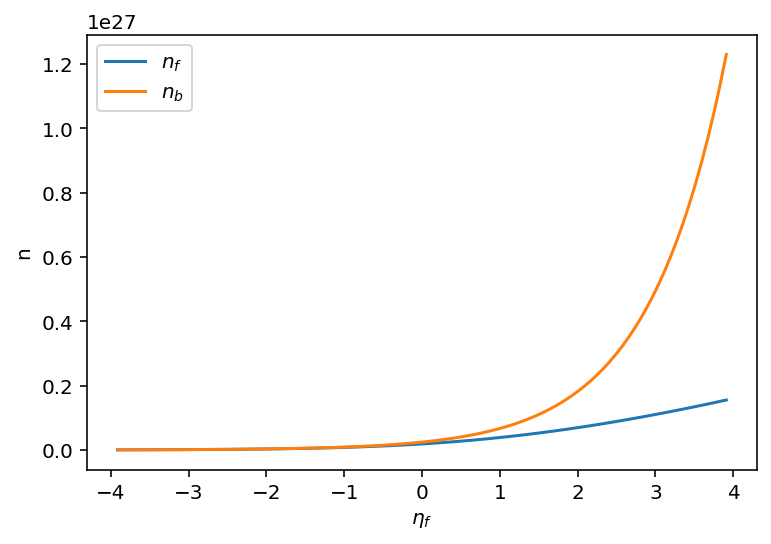

In [24]:
# Plot n_b against n_f - scale selected so the difference between energy levels is 0.1eV at either end
eta_f = np.linspace(-0.1*(1.6e-19)/(k_B*T), 0.1*(1.6e-19)/(k_B*T), 100)

fig = plt.figure(dpi=144)
plt.plot(eta_f, n_f(eta_f, m_0, T), label='$n_f$')
plt.plot(eta_f, n_b(eta_f, m_0, T), label='$n_b$')
plt.xlabel("$\eta_f$")
plt.ylabel("n")
# plt.title("Carrier Concentration against $\eta_f$")
plt.legend()

For $E_F = E_C - 100\text{meV}$ and $E_F = E_C + 50 \text{meV}$, we find $\eta_f$ is given by $\eta_f = -100 \text{meV} /k_BT$ and $\eta_f = +50 \text{meV} /k_B T$ respectively. We find the corresponding carrier concentrations to be given by

In [22]:
# For eta_f = eta_C - 100
eta_f_1 = np.array([- (100 * 1e-3 * 1.6e-19) / (k_B * T)])
eta_f_2 = np.array([50 * 1e-3 * 1.6e-19 / (k_B * T)])

# Calculate values for the first E_f
print(f"eta_f for E_f = E_C - 100me: {n_f(eta_f_1, m_0, T=T)[0]}")
print(f"eta_b for E_f = E_C - 100me: {n_b(eta_f_1, m_0, T=T)[0]}\n")

# Calculate values for the second E_f
print(f"eta_f for E_f = E_C - 100me: {n_f(eta_f_2, m_0, T=T)[0]}")
print(f"eta_b for E_f = E_C + 50me: {n_b(eta_f_2, m_0, T=T)[0]}")

eta_f for E_f = E_C - 100me: 4.8831182109584246e+23
eta_b for E_f = E_C - 100me: 4.9175125375841936e+23

eta_f for E_f = E_C - 100me: 6.786480948582944e+25
eta_b for E_f = E_C + 50me: 1.7389125748921083e+26


/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_2243/4081472078.py:9: RuntimeWarning: overflow encountered in exp
  integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))


### Question 3

Initially, I tried solving the problem using a library called py-pde, which specialises in solving PDEs. Unfortunately, the results it kept returning on the scale I was looking at were nonsensical. In the end, I found a YouTube video detailing a method that uses the FFT alogrithm, which I've used below. It, I must say, is quite elegant.

[ 5.00000000e+04 -4.87813952e+04  4.53009028e+04 ... -1.53840265e-08
  1.16033865e-08 -6.24789092e-09]


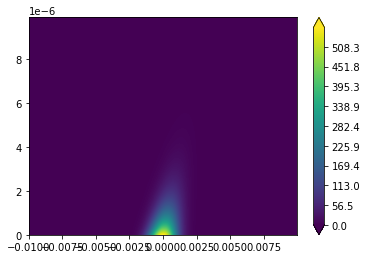

In [2]:
'''
FFT Method for solving PDEs
Code adapted from Steve Brunton's 'Solving PDEs with the FFT [Python]' YouTube tutorial
Source: https://www.youtube.com/watch?v=hDeARtZdq-U
Accessed 13/03/23
'''
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 10000 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
k_B = 1.381e-23 # J/K
D_p = (mu_p * k_B * T) / e

# Define the alpha value we will use to scale both the x-axis and the 
# distribution of carriers 
alpha = 1e6

# Set up p-values to solve for 
N = 1000 # Number of data points 
x_bound = 1e-2
dx = 2*x_bound/N
x = np.arange(-x_bound, x_bound, dx)

# Define a discrete set of wavenumbers 
k = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial Conditions (assuming a normalised gaussian)
def amplitude(alpha, area=1):
    return area*np.sqrt(alpha/np.pi)
amp = amplitude(alpha)
p_0 = amp*np.exp(-alpha*x**2)
p_0_fft = np.fft.fft(p_0)

# Sort out issues from imaginary numbers
p_0_fft_ri = np.concatenate((p_0_fft.real, p_0_fft.imag))
print(p_0_fft_ri)

# Set up the time domain
t_final = 1e-5
dt = t_final*1e-2
t = np.arange(0, t_final, dt)

# Define the rhs of the equation as a function for odeint
def rhs(p_fft_ri, t, k, D_p, mu_p, E_0, tau_p, T):
    p_fft = p_fft_ri[:N] + (1j) * p_fft_ri[N:] # Not sure what this line does either
    d_p_fft = -D_p*np.power(k, 2)*p_fft - (1j)*mu_p*E_0*k*p_fft - (1/tau_p)*p_fft
    d_p_fft_ri = np.concatenate((d_p_fft.real, d_p_fft.imag)).astype('float64')
    return d_p_fft_ri

# Integrate in the time domain to get the FFT of p
p_fft_ri = odeint(rhs, p_0_fft_ri, t, args=(k, D_p, mu_p, E_0, tau_p, T))

# Again, sorting out complex values 
p_fft = p_fft_ri[:, :N] + (1j) * p_fft_ri[:, N:]

# Create an array of zeros to fill with iFFT values
p = np.zeros_like(p_fft)

# Reverse Fourier Transform 
for k in range(len(t)):
    p[k,:] = np.fft.ifft(p_fft[k,:])
    
p = p.real

# Plot
plt.contourf(x, t, p, np.linspace(0, amp, N), extend='both')
plt.colorbar()

Now that I've got the code working, I can adapt it below into a function of $E_0$ and $T$

In [86]:
'''
FFT Method for solving PDEs
Code adapted from Steve Burton's 'Solving PDEs with the FFT [Python]' YouTube tutorial
Source: https://www.youtube.com/watch?v=hDeARtZdq-U
Accessed 13/03/23
'''
def system(E_0, T, alpha, x_bound=1e-2, t_start=0, mxsteps=0):
    mu_p = 300e-4 # m^2 V^-1 s^-1 
    T = T # K
    E_0 = E_0 # J
    tau_p = 1e-6 # s
    e = 1.6e-19 # C
    k_B = 1.381e-23 # J/K
    D_p = (mu_p * k_B * T) / e

    # Define the alpha value we will use to scale both the x-axis and the 
    # distribution of carriers 
    alpha = alpha

    # Set up p-values to solve for 
    N = 1000 # Number of data points 
    x_bound = x_bound
    dx = 2*x_bound/N
    x = np.arange(-x_bound, x_bound, dx)

    # Define a discrete set of wavenumbers 
    k = 2*np.pi*np.fft.fftfreq(N, d=dx)

    # Initial Conditions (assuming a normalised gaussian)
    def amplitude(alpha, area=1):
        return area*np.sqrt(alpha/np.pi)
    amp = amplitude(alpha)
    p_0 = amp*np.exp(-alpha*x**2)
    p_0_fft = np.fft.fft(p_0)

    # Sort out issues from imaginary numbers
    p_0_fft_ri = np.concatenate((p_0_fft.real, p_0_fft.imag))

    # Set up the time domain
    t_final = 1e-5
    dt = t_final*1e-2
    t = np.arange(t_start, t_final, dt)

    # Define the rhs of the equation as a function for odeint
    def rhs(p_fft_ri, t, k, D_p, mu_p, E_0, tau_p):
        p_fft = p_fft_ri[:N] + (1j) * p_fft_ri[N:] # Not sure what this line does either
        d_p_fft = -D_p*np.power(k, 2)*p_fft - (1j)*mu_p*E_0*k*p_fft - (1/tau_p)*p_fft
        d_p_fft_ri = np.concatenate((d_p_fft.real, d_p_fft.imag)).astype('float64')
        return d_p_fft_ri

    # Integrate in the time domain to get the FFT of p
    p_fft_ri = odeint(rhs, p_0_fft_ri, t, mxstep=mxsteps, args=(k, D_p, mu_p, E_0, tau_p))

    # Again, sorting out complex values 
    p_fft = p_fft_ri[:, :N] + (1j) * p_fft_ri[:, N:]

    # Create an array of zeros to fill with iFFT values
    p = np.zeros_like(p_fft)

    # Reverse Fourier Transform 
    for k in range(len(t)):
        p[k,:] = np.fft.ifft(p_fft[k,:])
        
    p = p.real

    # Plot
    plt.contourf(x*1e6, t*1e6, p, np.linspace(0, amp, N), extend='both')
    plt.xlabel("x ($\mu m$)")
    plt.ylabel("t ($\mu s$)")
    plt.colorbar()
    plt.show()

We can test the above for a variety of E-field values

E: 1 T: 100


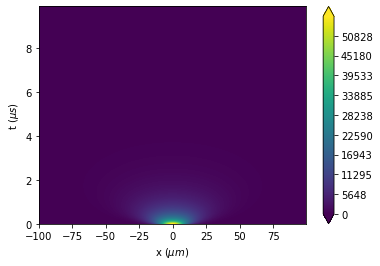

E: 10 T: 100


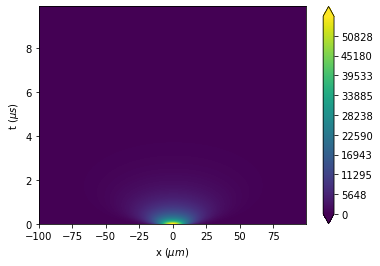

E: 100 T: 100


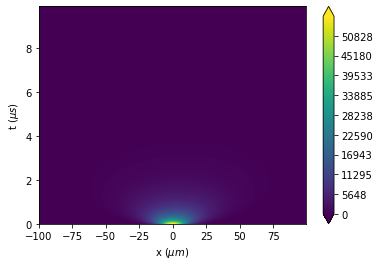

E: 1000 T: 100


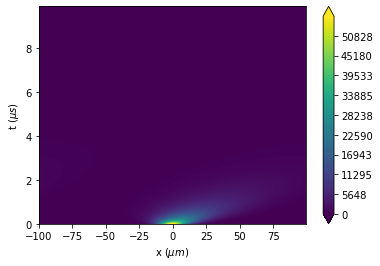

In [92]:
for index in range(4):
    E = 10**index
    T = 100
    print(f"E: {E}", f"T: {T}")
    system(E, T, 1e10, x_bound=1e-4, t_start=0, mxsteps=5000)

For varying $T$

E: 100 T: 0


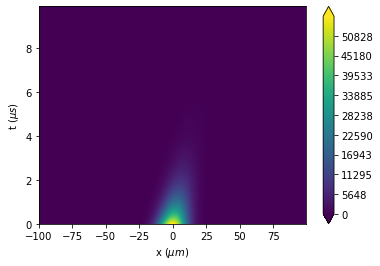

E: 100 T: 70


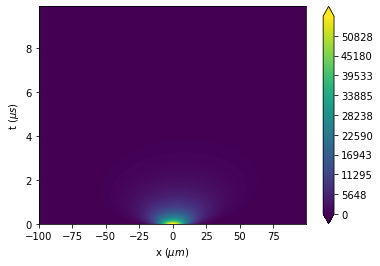

E: 100 T: 140


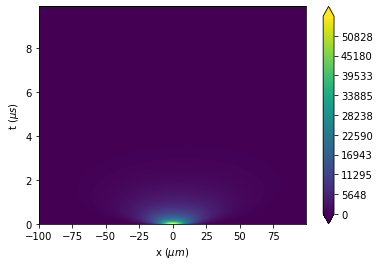

E: 100 T: 210


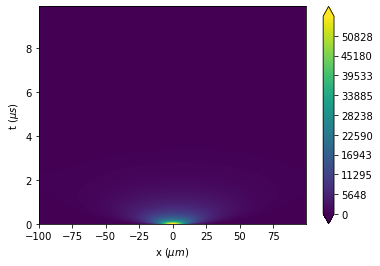

E: 100 T: 280


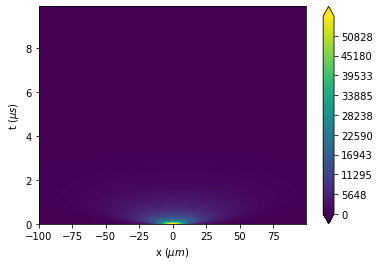

In [96]:
for index in range(0, 350, 70):
    E = 100
    T = index
    print(f"E: {E}", f"T: {T}")
    system(E, T, 1e10, x_bound=1e-4, t_start=0, mxsteps=5000)

Plot the analytic result to see what happens 

In [15]:
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.
k_B = 1.381E-23 # J/K

def delta_p_analytic(x, t, mu_p=mu_p, D_p=D_p, E_0=E_0, tau_p=tau_p):
    a = np.exp(-t/tau_p)/(4*np.pi*D_p*t)**2
    b = np.exp(-(x-mu_p*E_0*t)**2 / (4*D_p*t))
    return a*b

In [16]:
x_bound = 1e-4
y_bound = 1e-5
dt = y_bound*1e-2

x = np.linspace(-x_bound, x_bound, 101)
y = np.arange(10*dt, y_bound, dt)

X, Y = np.meshgrid(x, y)

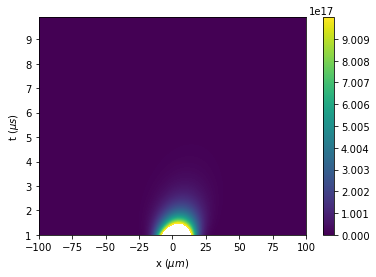

In [80]:
Z = delta_p_analytic(X, Y)

contours = np.linspace(0, 1e18, 1000)

plt.contourf(X*1e6, Y*1e6, Z, contours)
plt.xlabel("x ($\mu m$)")
plt.ylabel("t ($\mu s$)")
plt.colorbar()

In [21]:
delta_p_analytic(1e-9, 1e-9)

1.783612039569192e+20